In [1]:
import sys
from pathlib import Path

# Find project root by looking for 'src' directory
current_path = Path().resolve()

for parent in [current_path] + list(current_path.parents):
    if (parent / "src").exists():
        sys.path.insert(0, str(parent))
        print(f"Project root added to sys.path: {parent}")
        break
else:
    raise RuntimeError("Could not find project root containing 'src' directory")


Project root added to sys.path: /workspaces/Task_09_Project


In [2]:
!pip install statsmodels


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_raw_data
from src.preprocessing import clean_data
from src.modeling import train_linear_model
from src.evaluation import get_feature_importance


In [4]:
df_raw = load_raw_data("/workspaces/Task_09_Project/data/insurance.csv")
df_clean = clean_data(df_raw)

df_clean.head()


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


In [5]:
df_clean.dtypes


age                   int64
sex                   int64
bmi                 float64
children              int64
smoker                int64
charges             float64
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

In [6]:
model = train_linear_model(df_clean)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:44:49   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

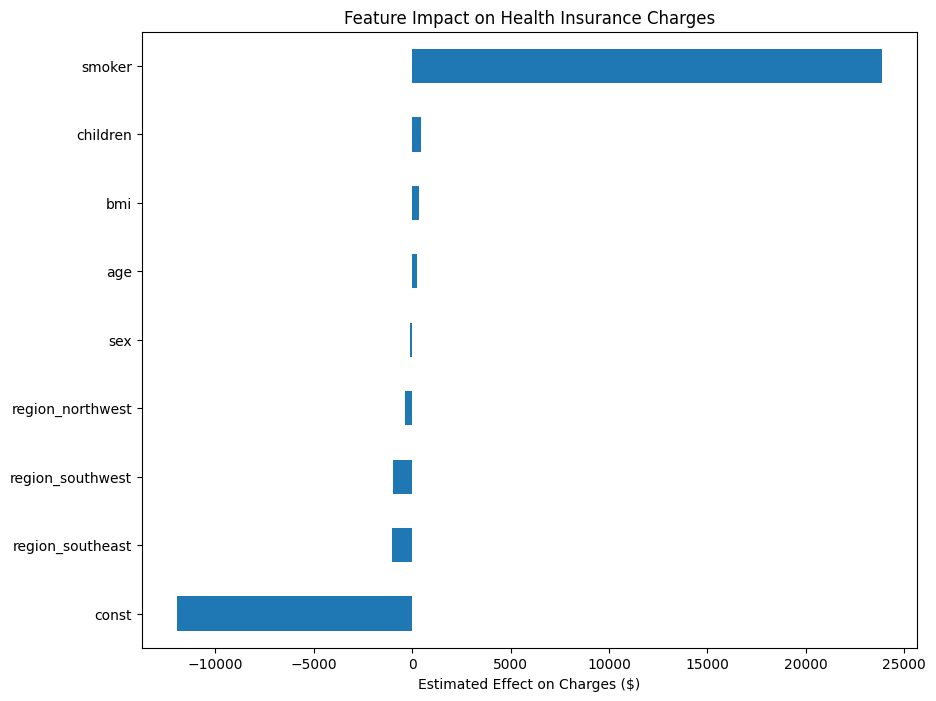

In [7]:
coef = get_feature_importance(model)

coef.plot(kind="barh", figsize=(10, 8))
plt.title("Feature Impact on Health Insurance Charges")
plt.xlabel("Estimated Effect on Charges ($)")
plt.show()


## Model Interpretation Summary

Smoking status is the strongest predictor of insurance charges, followed by age and BMI.
Family size and geographic region have comparatively smaller effects.
Log-transformed modeling confirms these relationships while reducing sensitivity to extreme values.
All results represent statistical associations, not causal claims.


In [8]:
import numpy as np

df_log = df_clean.copy()
df_log["log_charges"] = np.log(df_log["charges"])

log_model = train_linear_model(df_log.drop(columns=["charges"]), target="log_charges")
print(log_model.summary())


                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:44:49   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.0306      0.072  

## Model Diagnostics

### Coefficient Interpretation

In [9]:
coef_df = (
    log_model.params
    .drop("const")
    .to_frame("log_coef")
)

coef_df["percent_change"] = (np.exp(coef_df["log_coef"]) - 1) * 100
coef_df.sort_values("percent_change", key=abs, ascending=False)


,log_coef,percent_change
smoker,1.554323,373.188094
region_southeast,-0.157197,-14.546408
region_southwest,-0.128952,-12.098404
children,0.101857,10.722496
sex,-0.075416,-7.264279
region_northwest,-0.063788,-6.179571
age,0.034582,3.518654
bmi,0.013375,1.346467


### Residual Distribution

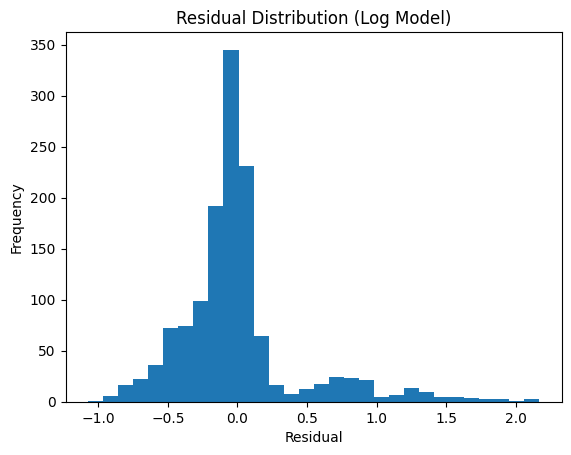

In [10]:
residuals = log_model.resid

plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residual Distribution (Log Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


### Predicted vs Actual

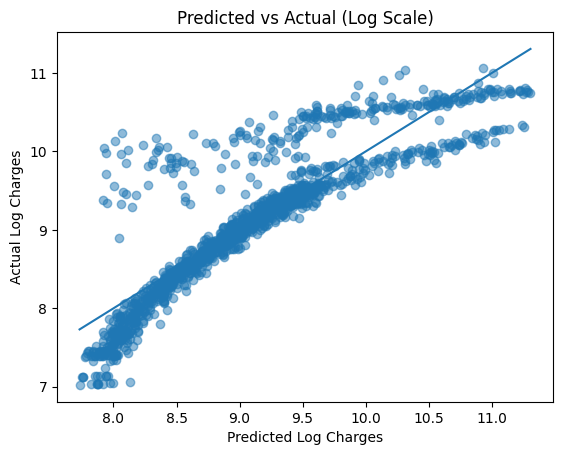

In [11]:
predicted = log_model.fittedvalues

plt.figure()
plt.scatter(predicted, log_model.model.endog, alpha=0.5)
plt.plot(
    [predicted.min(), predicted.max()],
    [predicted.min(), predicted.max()]
)
plt.xlabel("Predicted Log Charges")
plt.ylabel("Actual Log Charges")
plt.title("Predicted vs Actual (Log Scale)")
plt.show()
